In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Image based Colorectal Cancer diagnosis/dataset.zip" "dataset.zip"

In [ ]:
!unzip -q dataset.zip
!unzip -q dataset/dualclass.zip
!unzip -q dataset/test2classes.zip

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
class Residualblock(nn.Module):
    def __init__(self, in_channel, out_channel, Conv=False, strides=1):
        super().__init__()
        self.convolution1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=strides)
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        self.convolution2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)

        if Conv:
            self.convolution3 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides)
        else:
            self.convolution3 = None

    def forward(self, X):
        out = F.relu(self.batchnorm1(self.convolution1(X)))
        out = self.batchnorm2(self.convolution2(out))
        if self.convolution3:
            X = self.convolution3(X)
        out += X
        return F.relu(out)

def residualBlock(in_channel, out_channel, num_residuals, first_block=False):
    blks = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blks.append(Residualblock(in_channel, out_channel, Conv=True,
            strides=2))
        else:
            blks.append(Residualblock(out_channel, out_channel))
    
    return blks

class ResNet(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*residualBlock(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*residualBlock(64, 128, 2))
        self.b4 = nn.Sequential(*residualBlock(128, 256, 2))
        self.b5 = nn.Sequential(*residualBlock(256, 512, 2))
        self.finalLayer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),nn.Linear(512, n_classes))

        self.b1.apply(self.initialweight)
        self.b2.apply(self.initialweight)
        self.b3.apply(self.initialweight)
        self.b4.apply(self.initialweight)
        self.b5.apply(self.initialweight)
        self.finalLayer.apply(self.initialweight)

    def initialweight(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)
        


    def forward(self, X):
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.finalLayer(out)

        return out

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        
        data, target = data.to(device), target.to(device)  
        
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    


def validate(model, device, val_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in val_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(val_loader.dataset), acc.avg))
    return loss.avg,acc.avg
##define test function

def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  
        with torch.no_grad():
            
            output = model(data)
       
        loss_this = F.cross_entropy(output, target) 
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('dualclass/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
train_files, val_files, train_classes, val_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)

['NORM' 'TUM']


In [ ]:
with open('test2classes/files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)
test_files=files
test_classes = classes
print(len(test_files))
print(len(test_classes))

['NORM' 'TUM']
7200
7200


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 100 # We use a small batch size here for training
batch_size_test = 100 #
batch_size_val = 100

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('dualclass/', train_files, train_classes, 
                         transforms=image_transform)
val_dataset = Hist('dualclass/', val_files, val_classes, 
                         transforms=image_transform)
test_dataset = Hist('test2classes/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=batch_size_val, 
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


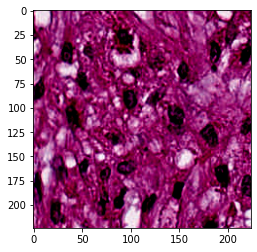

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(train_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
drive.flush_and_unmount()
!rm -rf /content/drive

In [ ]:
import os.path
from os import path
import torch.nn.functional as F
import torch.optim as optim

num_epoch = 30
accuracy_test=[]

for i in range(5):
  print('Experiment: ', i+1)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = ResNet(input_channel=3, n_classes=2).to(device)
  learning_rate = 0.0005
  weight_decay = 0.001
  for param in model.parameters():
    param.requires_grad = True
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

  acc=0
  for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=validate(model, device, val_loader)
    if acc<acct:
      if path.exists("ResNet2SGD.pth"):
        os.remove("ResNet2SGD.pth")
      torch.save(model.state_dict(), 'ResNet2SGD.pth')
      acc=acct

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = ResNet(input_channel=3, n_classes=2).to(device)
  model.load_state_dict(torch.load('ResNet2SGD.pth', map_location=device))
  model=model.to(device)
  
  l,a=test(model, device, test_loader)
  accuracy_test.append(a)
print(accuracy_test)

Experiment:  1
1


<ipython-input-6-7ceae6cba87a>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.3930

Test: Average loss: 0.2005, Accuracy: 8435/9096 (92.73%)

2


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1711

Test: Average loss: 0.1314, Accuracy: 8660/9096 (95.21%)

3


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1405

Test: Average loss: 0.1587, Accuracy: 8503/9096 (93.48%)

4


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1255

Test: Average loss: 0.1119, Accuracy: 8716/9096 (95.82%)

5


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1152

Test: Average loss: 0.1269, Accuracy: 8647/9096 (95.06%)

6


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1022

Test: Average loss: 0.2530, Accuracy: 8370/9096 (92.02%)

7


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0999

Test: Average loss: 0.0850, Accuracy: 8811/9096 (96.87%)

8


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0887

Test: Average loss: 0.0856, Accuracy: 8800/9096 (96.75%)

9


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0808

Test: Average loss: 0.0780, Accuracy: 8841/9096 (97.20%)

10


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0755

Test: Average loss: 0.1209, Accuracy: 8648/9096 (95.07%)

11


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0683

Test: Average loss: 0.0915, Accuracy: 8782/9096 (96.55%)

12


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0656

Test: Average loss: 0.1181, Accuracy: 8668/9096 (95.29%)

13


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0574

Test: Average loss: 0.0614, Accuracy: 8897/9096 (97.81%)

14


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0600

Test: Average loss: 0.0651, Accuracy: 8876/9096 (97.58%)

15


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0572

Test: Average loss: 0.1389, Accuracy: 8570/9096 (94.22%)

16


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0552

Test: Average loss: 0.0628, Accuracy: 8880/9096 (97.63%)

17


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0441

Test: Average loss: 0.0650, Accuracy: 8882/9096 (97.65%)

18


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0434

Test: Average loss: 0.0836, Accuracy: 8812/9096 (96.88%)

19


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0391

Test: Average loss: 0.0732, Accuracy: 8847/9096 (97.26%)

20


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0348

Test: Average loss: 0.1378, Accuracy: 8696/9096 (95.60%)

21


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0339

Test: Average loss: 0.0729, Accuracy: 8845/9096 (97.24%)

22


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0289

Test: Average loss: 0.0713, Accuracy: 8861/9096 (97.42%)

23


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0285

Test: Average loss: 0.0563, Accuracy: 8906/9096 (97.91%)

24


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0260

Test: Average loss: 0.0574, Accuracy: 8909/9096 (97.94%)

25


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0235

Test: Average loss: 0.0766, Accuracy: 8864/9096 (97.45%)

26


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0238

Test: Average loss: 0.0739, Accuracy: 8846/9096 (97.25%)

27


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0187

Test: Average loss: 0.0737, Accuracy: 8853/9096 (97.33%)

28


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0150

Test: Average loss: 0.0624, Accuracy: 8907/9096 (97.92%)

29


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0164

Test: Average loss: 0.1054, Accuracy: 8744/9096 (96.13%)

30


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0147

Test: Average loss: 0.1060, Accuracy: 8822/9096 (96.99%)

Test: Average loss: 0.0400, Accuracy: 7106/7200 (98.69%)

Experiment:  2
1


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.4241

Test: Average loss: 0.2155, Accuracy: 8354/9096 (91.84%)

2


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1731

Test: Average loss: 0.1423, Accuracy: 8616/9096 (94.72%)

3


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1353

Test: Average loss: 0.1334, Accuracy: 8637/9096 (94.95%)

4


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1217

Test: Average loss: 0.1080, Accuracy: 8735/9096 (96.03%)

5


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1052

Test: Average loss: 0.0917, Accuracy: 8794/9096 (96.68%)

6


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0999

Test: Average loss: 0.1105, Accuracy: 8695/9096 (95.59%)

7


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0898

Test: Average loss: 0.1031, Accuracy: 8724/9096 (95.91%)

8


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0858

Test: Average loss: 0.0966, Accuracy: 8750/9096 (96.20%)

9


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0813

Test: Average loss: 0.1245, Accuracy: 8668/9096 (95.29%)

10


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0761

Test: Average loss: 0.0859, Accuracy: 8777/9096 (96.49%)

11


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0718

Test: Average loss: 0.0678, Accuracy: 8871/9096 (97.53%)

12


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0622

Test: Average loss: 0.1464, Accuracy: 8540/9096 (93.89%)

13


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0635

Test: Average loss: 0.1485, Accuracy: 8674/9096 (95.36%)

14


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0611

Test: Average loss: 0.0670, Accuracy: 8883/9096 (97.66%)

15


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0579

Test: Average loss: 0.0736, Accuracy: 8858/9096 (97.38%)

16


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0527

Test: Average loss: 0.0672, Accuracy: 8873/9096 (97.55%)

17


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0456

Test: Average loss: 0.0813, Accuracy: 8823/9096 (97.00%)

18


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0432

Test: Average loss: 0.0724, Accuracy: 8867/9096 (97.48%)

19


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0403

Test: Average loss: 0.0649, Accuracy: 8880/9096 (97.63%)

20


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0369

Test: Average loss: 0.0624, Accuracy: 8893/9096 (97.77%)

21


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0338

Test: Average loss: 0.1232, Accuracy: 8691/9096 (95.55%)

22


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0321

Test: Average loss: 0.0580, Accuracy: 8913/9096 (97.99%)

23


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0265

Test: Average loss: 0.0670, Accuracy: 8875/9096 (97.57%)

24


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0241

Test: Average loss: 0.0711, Accuracy: 8883/9096 (97.66%)

25


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0190

Test: Average loss: 0.0641, Accuracy: 8876/9096 (97.58%)

26


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0218

Test: Average loss: 0.1517, Accuracy: 8596/9096 (94.50%)

27


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0171

Test: Average loss: 0.1814, Accuracy: 8520/9096 (93.67%)

28


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0167

Test: Average loss: 0.0573, Accuracy: 8916/9096 (98.02%)

29


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0138

Test: Average loss: 0.0646, Accuracy: 8903/9096 (97.88%)

30


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0118

Test: Average loss: 0.0831, Accuracy: 8865/9096 (97.46%)

Test: Average loss: 0.0369, Accuracy: 7115/7200 (98.82%)

Experiment:  3
1


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.4175

Test: Average loss: 0.1921, Accuracy: 8435/9096 (92.73%)

2


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1733

Test: Average loss: 0.1661, Accuracy: 8517/9096 (93.63%)

3


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1366

Test: Average loss: 0.1717, Accuracy: 8444/9096 (92.83%)

4


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1180

Test: Average loss: 0.1076, Accuracy: 8708/9096 (95.73%)

5


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1094

Test: Average loss: 0.1013, Accuracy: 8767/9096 (96.38%)

6


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0975

Test: Average loss: 0.0926, Accuracy: 8798/9096 (96.72%)

7


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0887

Test: Average loss: 0.0992, Accuracy: 8762/9096 (96.33%)

8


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0844

Test: Average loss: 0.0791, Accuracy: 8841/9096 (97.20%)

9


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0777

Test: Average loss: 0.3539, Accuracy: 7797/9096 (85.72%)

10


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0697

Test: Average loss: 0.1194, Accuracy: 8704/9096 (95.69%)

11


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0681

Test: Average loss: 0.0728, Accuracy: 8861/9096 (97.42%)

12


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0645

Test: Average loss: 0.0863, Accuracy: 8780/9096 (96.53%)

13


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0606

Test: Average loss: 0.1238, Accuracy: 8639/9096 (94.98%)

14


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0586

Test: Average loss: 0.1030, Accuracy: 8742/9096 (96.11%)

15


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0546

Test: Average loss: 0.0738, Accuracy: 8852/9096 (97.32%)

16


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0477

Test: Average loss: 0.1921, Accuracy: 8491/9096 (93.35%)

17


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0457

Test: Average loss: 0.1370, Accuracy: 8710/9096 (95.76%)

18


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0406

Test: Average loss: 0.0868, Accuracy: 8821/9096 (96.98%)

19


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0418

Test: Average loss: 0.0712, Accuracy: 8850/9096 (97.30%)

20


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0373

Test: Average loss: 0.1150, Accuracy: 8720/9096 (95.87%)

21


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0354

Test: Average loss: 0.0620, Accuracy: 8910/9096 (97.96%)

22


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0338

Test: Average loss: 0.0593, Accuracy: 8905/9096 (97.90%)

23


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0258

Test: Average loss: 0.0736, Accuracy: 8883/9096 (97.66%)

24


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0252

Test: Average loss: 0.0559, Accuracy: 8908/9096 (97.93%)

25


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0248

Test: Average loss: 0.1270, Accuracy: 8782/9096 (96.55%)

26


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0208

Test: Average loss: 0.0600, Accuracy: 8897/9096 (97.81%)

27


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0171

Test: Average loss: 0.1302, Accuracy: 8701/9096 (95.66%)

28


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0193

Test: Average loss: 0.0776, Accuracy: 8871/9096 (97.53%)

29


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0161

Test: Average loss: 0.0658, Accuracy: 8894/9096 (97.78%)

30


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0164

Test: Average loss: 0.0620, Accuracy: 8907/9096 (97.92%)

Test: Average loss: 0.0506, Accuracy: 7079/7200 (98.32%)

Experiment:  4
1


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.4012

Test: Average loss: 0.2340, Accuracy: 8241/9096 (90.60%)

2


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1726

Test: Average loss: 0.2048, Accuracy: 8298/9096 (91.23%)

3


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1526

Test: Average loss: 0.1216, Accuracy: 8700/9096 (95.65%)

4


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1248

Test: Average loss: 0.1416, Accuracy: 8567/9096 (94.18%)

5


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1099

Test: Average loss: 0.1120, Accuracy: 8688/9096 (95.51%)

6


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1003

Test: Average loss: 0.2332, Accuracy: 8277/9096 (91.00%)

7


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0939

Test: Average loss: 0.0917, Accuracy: 8783/9096 (96.56%)

8


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0891

Test: Average loss: 0.0982, Accuracy: 8764/9096 (96.35%)

9


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0766

Test: Average loss: 0.0772, Accuracy: 8846/9096 (97.25%)

10


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0742

Test: Average loss: 0.1216, Accuracy: 8686/9096 (95.49%)

11


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0687

Test: Average loss: 0.0913, Accuracy: 8776/9096 (96.48%)

12


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0656

Test: Average loss: 0.0955, Accuracy: 8762/9096 (96.33%)

13


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0627

Test: Average loss: 0.1227, Accuracy: 8693/9096 (95.57%)

14


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0559

Test: Average loss: 0.0580, Accuracy: 8905/9096 (97.90%)

15


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0512

Test: Average loss: 0.0711, Accuracy: 8856/9096 (97.36%)

16


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0533

Test: Average loss: 0.0691, Accuracy: 8865/9096 (97.46%)

17


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0463

Test: Average loss: 0.0700, Accuracy: 8855/9096 (97.35%)

18


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0415

Test: Average loss: 0.0838, Accuracy: 8802/9096 (96.77%)

19


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0447

Test: Average loss: 0.0966, Accuracy: 8787/9096 (96.60%)

20


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0382

Test: Average loss: 0.0691, Accuracy: 8854/9096 (97.34%)

21


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0324

Test: Average loss: 0.0746, Accuracy: 8852/9096 (97.32%)

22


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0340

Test: Average loss: 0.0877, Accuracy: 8816/9096 (96.92%)

23


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0312

Test: Average loss: 0.0632, Accuracy: 8881/9096 (97.64%)

24


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0296

Test: Average loss: 0.0724, Accuracy: 8864/9096 (97.45%)

25


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0278

Test: Average loss: 0.0846, Accuracy: 8824/9096 (97.01%)

26


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0200

Test: Average loss: 0.0889, Accuracy: 8808/9096 (96.83%)

27


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0249

Test: Average loss: 0.0756, Accuracy: 8861/9096 (97.42%)

28


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0201

Test: Average loss: 0.0558, Accuracy: 8897/9096 (97.81%)

29


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0170

Test: Average loss: 0.1325, Accuracy: 8675/9096 (95.37%)

30


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0161

Test: Average loss: 0.0546, Accuracy: 8916/9096 (98.02%)

Test: Average loss: 0.0517, Accuracy: 7085/7200 (98.40%)

Experiment:  5
1


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.4236

Test: Average loss: 0.3987, Accuracy: 7321/9096 (80.49%)

2


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1770

Test: Average loss: 0.1692, Accuracy: 8457/9096 (92.97%)

3


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1418

Test: Average loss: 0.1261, Accuracy: 8659/9096 (95.20%)

4


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1246

Test: Average loss: 0.1208, Accuracy: 8679/9096 (95.42%)

5


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1071

Test: Average loss: 0.1464, Accuracy: 8561/9096 (94.12%)

6


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.1011

Test: Average loss: 0.1364, Accuracy: 8595/9096 (94.49%)

7


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0936

Test: Average loss: 0.0987, Accuracy: 8774/9096 (96.46%)

8


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0860

Test: Average loss: 0.0784, Accuracy: 8834/9096 (97.12%)

9


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0816

Test: Average loss: 0.0888, Accuracy: 8798/9096 (96.72%)

10


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0726

Test: Average loss: 0.0801, Accuracy: 8812/9096 (96.88%)

11


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0639

Test: Average loss: 0.0889, Accuracy: 8808/9096 (96.83%)

12


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0635

Test: Average loss: 0.0686, Accuracy: 8867/9096 (97.48%)

13


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0602

Test: Average loss: 0.0834, Accuracy: 8804/9096 (96.79%)

14


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0587

Test: Average loss: 0.0671, Accuracy: 8869/9096 (97.50%)

15


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0509

Test: Average loss: 0.0716, Accuracy: 8852/9096 (97.32%)

16


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0463

Test: Average loss: 0.0573, Accuracy: 8891/9096 (97.75%)

17


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0431

Test: Average loss: 0.1068, Accuracy: 8710/9096 (95.76%)

18


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0403

Test: Average loss: 0.1422, Accuracy: 8657/9096 (95.17%)

19


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0407

Test: Average loss: 0.0561, Accuracy: 8912/9096 (97.98%)

20


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0364

Test: Average loss: 0.1096, Accuracy: 8706/9096 (95.71%)

21


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0325

Test: Average loss: 0.0556, Accuracy: 8917/9096 (98.03%)

22


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0283

Test: Average loss: 0.0751, Accuracy: 8874/9096 (97.56%)

23


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0245

Test: Average loss: 0.0837, Accuracy: 8822/9096 (96.99%)

24


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0232

Test: Average loss: 0.1099, Accuracy: 8762/9096 (96.33%)

25


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0238

Test: Average loss: 0.0776, Accuracy: 8861/9096 (97.42%)

26


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0212

Test: Average loss: 0.0542, Accuracy: 8921/9096 (98.08%)

27


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0168

Test: Average loss: 0.0610, Accuracy: 8910/9096 (97.96%)

28


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0160

Test: Average loss: 0.0791, Accuracy: 8848/9096 (97.27%)

29


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0166

Test: Average loss: 0.0571, Accuracy: 8909/9096 (97.94%)

30


  0%|          | 0/213 [00:00<?, ?it/s]

Train: Average loss: 0.0121

Test: Average loss: 0.0881, Accuracy: 8854/9096 (97.34%)

Test: Average loss: 0.0354, Accuracy: 7114/7200 (98.81%)

[98.69444444444444, 98.81944444444444, 98.31944444444444, 98.40277777777777, 98.80555555555556]


In [ ]:
import numpy as np
acc=np.array([98.69444444444444, 98.81944444444444, 98.31944444444444, 98.40277777777777, 98.80555555555556])
print(np.mean(acc))
print(np.std(acc))

98.60833333333332
0.20812952994365921
